# 6 Computational complexity: kSAT

In this exercise you will numerically investigate a phase transition in an ensemble of problems in mathematical logic, called kSAT. In particular, you will examine how the computational difficulty of the problems grows near the critical point. This noteboook ties together a number of fundamental issues in critical phenomena, computer science, and mathematical logic. The kSAT problem we study is one in a class of problems called NP–complete. P and NP–complete are defined for deterministic, single-processor computers. There are polynomial-time algorithms for solving some problems (like prime factorization) on a quantum computer, if we can figure out how to build one. In other exercises, we have explored how the speed of algorithms for solving computational problems depends on the size N of the system. Sorting a list of N elements, for example, can be done using of order N log N size comparisons between elements.  Computer scientists categorize problems into complexity classes; for example, a problem is in P if it can guarantee a solution in a time that grows no faster than a polynomial in the size N. Sorting lists is in P (the time grows more slowly than N$^2$ , for example, since N log N < N$^2$ for large N); telling whether an N digit number is prime has recently been shown also to be in P. A problem is in NP if a proposed solution can be verified in polynomial time. For example, factoring an integer with N digits is not known to be in P (since there is no known algorithm for finding the factors of an N-digit integer) that runs in a time polynomial in N), but it is in NP. Just because a problem is NP–complete does not make a typical instance of the problem numerically challenging. The classification is determined by worst-case scenarios, not by the ensemble of typical problems. If the difficult problems are rare, the average time for solution might be acceptable even though some problems in the ensemble will take exponentially long times to run.

The kSAT problem involves N boolean variables. The logical expression can use the operations NOT (¬), AND (∧), and OR (∨). It is satisfiable if there is some assignment of True and False to its variables that makes the expression True.

In this notebook, yoy will implement algorithms to solve examples of kSAT problems, and apply them to the ensemble of random 2SAT and 3SAT problems with M clauses. We will see that, in the limit of large numbers of variables N, the fraction of satisfiable kSAT problems undergoes a phase transition as the number M/N of clauses per variable grows. Each new clause reduces the scope for possible solutions. The random kSAT problems with few clauses per variable are almost always satisfiable, and it is easy to find a solution; the random kSAT problems with many clauses per variable are almost always not satisfi- able, and it is easy to find a contradiction. Only near the critical point where the mean number of solutions vanishes as N → ∞ is determining satisfiability typically a challenge.

A logical expression in conjunctive normal form with N variables Xm can conveniently be rep- resented on the computer as a list of sublists of non-zero integers in the range [−N,N], with each integer representing a literal (−m representing ¬Xm) each sublist representing a disjunction (OR) of its literals, and the list as a whole rep- resenting the conjunction (AND) of its sublists. Thus [[−3, 1, 2], [−2, 3, −1]] would be the expression ((¬X3) ∨ X1 ∨ X2) ∧ ((¬X2) ∨ X3 ∨ (¬X1)).

Note: you can make use of a graphical software loading DynamicNetwork.py

In [1]:
import pylab, random, math, time
import numpy as np

In [2]:
!pip install Pillow

In [3]:
from PIL import ImageTk, Image, ImageDraw

In [4]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [5]:
import sys, os
sys.path.append('/content/drive/MyDrive/Colab Notebooks/LAB COMPLEX systems')

# Replace 'path_to_directory_containing_file' with the actual path to the directory where your .py file is located in your Google Drive.

# Now import your module
import DynamicNetwork

In [6]:
# Use to control whether you animate your solution
# Set to False if you want to run quickly
GRAPHICS = False


#### Exercise 6.1: Colorability
We first generate some "real-world" logical satisfiability problems that emerge from graph coloring. This is mostly to give a feeling for what SAT problems are, and to give a couple of examples where we know the answer, to be used to debug our algorithms.

Can the N nodes of a graph be colored in three colors (say red, green, and blue) so that no two nodes joined by an edge have the same color?3 For an N-node graph one can of course explore the entire ensemble of 3N colorings, but that takes a time exponential in N. Sadly, there are no known short-cuts that fundamentally change this; there is no known algorithm for determining whether a given N-node graph is three-colorable that guarantees an answer in a time that grows only as a power of N.

One can show that a 3-colorability problem with N nodes can be mapped onto a logical satisfiability problem with 3N variables, so a polynomial-time (non- exponential) algorithm for the SAT would imply a (hitherto unknown) polynomial-time solution algo- rithm for 3-colorability. In this exercise you will transform a 3-colorability problem into a SAT problem.



In [7]:
def MakeSATFrom3Colorability(colorGraphDict):
    """Transform a 3-colorability problem into a SAT exercise.
    Assume that the graph to be colored is a dictionary, with
    keys labeling the nodes of the graph, and lists of neighbors
    as edges for each node. We assume an undirected graph, so if
    A has B in its list of neighbors, so B has A in its list.
    Assume colorGraphDict gives the neighbors of each edge:
        ['A'] = ['B', 'C', 'D']
    Given an N-node graph, make up a 3N-variable SAT problem
    where node A has three logical variables A_red, A_green, and A_blue.
    #
    Let's do this systematically.
    (1) Define three dictionaries red, green, and blue, by iterating
    over the nodes ("for node in colorGraphDict");
    for the nth node [counting from zero] red=3*n+1, green=3*n+2,
    and blue=3*n+3. (We'll use the negatives of these variables to denote
    the logical statement that the node is not colored that color:
    not-red = -(3*n+1), etc.)
    Each clause is a list of at most three integers (minus for "not"), so
    [6, -7, 3] says "node 2 is blue or node 3 is not red or node 1 is blue".
        Of course, that example will not show up in a classic 3-coloring problem
        -- examples of more typical clauses are:
        [1, 2, 3] -- "node 1 is red or blue or green"
        [-1, -4] -- "either node 1 is not red or node 2 is not red"  whcih is easier
        to understand as "node 1 and node 2 are not both red"
        [-1,-2] -- "node 1 is not both red and blue"
    (2) Then generate the clauses, appending to an empty list
    For each node,
     Append a clause saying that the node is colored at least one color
     Append three clauses saying that the node is not colored two colors
     For each edge (say between A and B), if B>A (to avoid double counting)
       append three clauses saying that
       A and B are not colored the same color
    (3) Return the clauses
    """
    red = {}
    green={}
    blue={}
    clauses = []
    mappedDict = dict(zip(colorGraphDict.keys(), range(1, len(colorGraphDict)+1)))
    for node in colorGraphDict.keys():
      n = mappedDict[node]
      red[node] = 3*n+1
      green[node] = 3*n+2
      blue[node] = 3*n+3
      clauses.append((3*n+1, 3*n+2, 3*n+3)) #at least 1 color
      clauses.append((-3*n-1, -3*n-2)) #not 2 colors at the same time
      clauses.append((-3*n-2, -3*n-3))
      clauses.append((-3*n-1, -3*n-3))
      for edge in colorGraphDict[node]:
        m = mappedDict[edge]
        if m>n:
          clauses.append((-3*n-1, -3*m-1))
          clauses.append((-3*n-2, -3*m-2))
          clauses.append((-3*n-3, -3*m-3))

    return clauses

Here are two examples of graphs with N nodes that can and cannot be colored with 3 colors:

![image.png](attachment:c63ea59d-6735-43e1-a2b7-f12e6186d7a9.png)

Generate, by hand, the two maps in, as dictionaries:
    
    leftGraph={}
    
    leftGraph['A']=['B','C','D'],
    ...
    
    return leftGraph, rightGraph


In [8]:
def MakeMapsFromProblemSet():
    """Generate, by hand, the two maps in the Graph Coloring figure
    in the Satisfactory Map Coloring exercise, as dictionaries:
    leftGraph={}
    leftGraph['A']=['B','C','D'],
    ...
    return leftGraph, rightGraph
    """
    leftGraph = {}
    leftGraph["A"] = ["B", "C", "D"]
    leftGraph["B"] = ["A", "C"]
    leftGraph["C"] = ["A", "B", "D"]
    leftGraph["D"] = ["A", "C"]

    rightGraph ={}
    rightGraph["A"] = ["B", "C", "D"]
    rightGraph["B"] = ["A", "C", "D"]
    rightGraph["C"] = ["A", "B", "D"]
    rightGraph["D"] = ["A", "B", "C"]

    return leftGraph, rightGraph

In [9]:
MakeSATFrom3Colorability(MakeMapsFromProblemSet()[0])

[(4, 5, 6),
 (-4, -5),
 (-5, -6),
 (-4, -6),
 (-4, -7),
 (-5, -8),
 (-6, -9),
 (-4, -10),
 (-5, -11),
 (-6, -12),
 (-4, -13),
 (-5, -14),
 (-6, -15),
 (7, 8, 9),
 (-7, -8),
 (-8, -9),
 (-7, -9),
 (-7, -10),
 (-8, -11),
 (-9, -12),
 (10, 11, 12),
 (-10, -11),
 (-11, -12),
 (-10, -12),
 (-10, -13),
 (-11, -14),
 (-12, -15),
 (13, 14, 15),
 (-13, -14),
 (-14, -15),
 (-13, -15)]

#### Exercise 6.2: The Devis-Putnam algorithm

The DP (Davis–Putnam) algorithm for determining satisfiability is recursive. Tentatively set a variable to true, reduce the clauses involving the variable, and apply DP to the remainder. If the remainder is satisfiable, return satisfiable. Otherwise set the variable to false, again reduce the clauses involving the variable, and return DP applied to the remainder.
To implementing DP, you will want to introduce (i) a data structure that connects a variable to the clauses that contain it, and to the clauses that contain its negation, and (ii) a record of which clauses are already known to be true (because one of its lit- erals has been tentatively set true). You will want a reduction routine which tentatively sets one variable, and returns the variables and clauses changed. (If we reach a dead end—a contradiction forcing us to unset the variable—we’ll need these changes in order to back up.) The recursive solver which calls the reduction routine should return not only whether the network is satisfiable, and the solution if it exists, but also the number of dead ends that it reached.

Implement the DP algorithm. Apply it to your 3-colorability expressions from Exercise 6.1


In [10]:
from collections import defaultdict, Counter

In [11]:
class DPSATSolverBase:
    """
    SATSolverBase implements a Davis-Putnam algorithm for finding solutions
    to logical satisfiability problems stated in conjunctive normal form.

    This is a "base class", or virtual class: it does not implement
    one key method (TrySet), but awaits two different implementations
    (SlowDPSATSolver and FasterDPSATSolver) in classes derived from
    SATSolverBase.
    """

    def __init__(self, clauseList=None):
        """Constructs a SATSolverBase given a set of input clauses.
        It needs to create and store the following data members:

        self.clauseList: the list of input clauses, each one consisting of
        a list of variables and negations of variables (stored as a list
        of signed integers)

        self.vars: a list of the variables. This internal list will be
        used also to determine the order in which the variables are
        tried (given tentative values). Shuffling or reordering this
        list will be an important diagnostic and optimization tool.
        Until we start the fancy methods, be sure to sort this list
        (self.vars.sort()) after it is assembled from the
        clauses, so that your algorithm will set variables in the same
        order as the graphics program lays them out.

        self.varStatus: a dictionary mapping variables to boolean
        values True or False, or None if variable is (so far) unset

        self.nodeClauses: a dictionary mapping a variable
        to the indices of the clauses including that variable and maps
        its negation to those for clauses including the negation of that
        variable. Specifically, if clauseList[i]=[n,-m,p] then
        nodeClauses[n]=[..., i, ...] contains i, as should nodeClauses[-m]
        and nodeClauses[p].

        self.clauseStatus: a dictionary identifying
        whether the clause is not determined (None), or if it is True
        give the current state of the variables. (If a clause
        is False, for this algorithm, we immediately backtrack.)

        if GRAPHICS is set to True, create
        self.dynnet: an instance of a DynamicNetwork graphics window
        for animating solver progress
        (self.dynnet = DynamicNetwork.DynamicNetwork())
        """
        self.clauseList = clauseList
        self.vars = []
        self.nodeClauses = defaultdict(list)
        for index, clause in enumerate(self.clauseList):
            for element2 in clause:
                self.nodeClauses[abs(element2)].append(index)
                if abs(element2) not in self.vars:
                    self.vars.append(abs(element2))
        self.vars.sort()
        self.varStatus = {var: None for var in self.vars}
        self.clauseStatus = {clause: None for clause in self.clauseList}
        if GRAPHICS:
            self.dynnet = DynamicNetwork.DynamicNetwork()

    def SelectNextVariableToTry(self, MOMS=False, method=max):
        """Gives next variable (index entry into list vars) for DP algorithm
        to try setting. Initially we explore the simple algorithm of
        just setting them in order: later we'll select them in MOMS order"""
        if MOMS:
            return self.SelectNextVariableMOMS(method=method)
        return self.SelectNextVariableSimple()

    def SelectNextVariableSimple(self):
        """Search through self.vars for the first unset variable
        (the index for which varStatus[vars[varIndex]] is None). If all are
        set (we're done!) return None; otherwise return varIndex.
        """
        for varIndex, var in enumerate(self.vars):
            if self.varStatus[var] is None:
                return var
        return None

    def SelectNextVariableMOMS(self, method=max):
        """Select one of the MOMS literals (Most Occurences in unresolved
        clauses of Minimial Size) at random. Also, if there are no
        unresolved clauses, return None to signal that a SAT solution
        has been found.
        "Size" refers to the number of unset variables in the clause.
        Usually the minimal size will be two. (`Length one' literals will
        be reduced by FasterDPSATSolver.TrySet).
        (1) Assemble a list MSVars of the unset variables in unresolved clauses
                of minimal size:
                Set k=1;  # the Fast solver can start at k=2, but the Slow one
                                                # needs to start at k=1
                while no unresolved clauses of length k exist:
                    Loop over clauses,
                        if the clause is not True (resolved)
                    build a list of unset variables in the clause
                    if that list has k variables,
                        note that length k clauses exist
                        extend the list of MSVars
                    If no unresolved clauses exist, return None
                    Increment k
        (2) Find the number of times each variable is contained in MSVars,
        and the maximum number
        (3) Collect the list of MOMS variables represented most often
        (4) Use random.choice to return random choice among MOMS variables"""
        k = 1
        k_unsolved = False
        unres_exists = False
        MSVars = []
        while not k_unsolved:
            for clause in self.clauseList:
                if self.clauseStatus[clause] != True:  # if the clause is not true
                    unres_exists = True
                    unsolved_vars = []
                    for lit in clause:
                        var = abs(lit)
                        if self.varStatus[var] is None:
                            unsolved_vars.append(var)  # build list of unset variable
                    if len(unsolved_vars) == k:
                        k_unsolved = True
                        for var in unsolved_vars:
                            MSVars.append(var)
            if not unres_exists:
                return None
            k += 1
        counts = Counter(MSVars)
        max_count = method(counts.values())
        most_frequent = [elem for elem, count in counts.items() if count == max_count]
        return random.choice(most_frequent)

    def Solve(self,numTries = 0,MOMS = False, method=max, stop_criterion=False, steps=0):
        """Solve() returns True if the clauses are satisfiable (SAT)
        and False if UNSAT, along with the number of tries required
        to find a solution. Solve() also leaves "self" in a solved
        state if it found one.
        #
        Solve works by
        (0) initializing numTries = 0
        (1) selecting a literal litNext to try setting next. If all
        variables are set, declare victory: return True and numTries(=0)
        (2) loop over literal in [litNext, -litNext]
              calling TrySet on that literal, incrementing numTries
              If TrySet returns True, Solve recursively calls itself,
            and supplements numTries.
                  If this recursive call returns true, Solve declares
              victory and returns True and numTries
              Otherwise, unwind: set the status of the variables in varsSet
              and clauses in clausesSet to None
        (3) return False, numTries
        Also, if GRAPHICS==True, call Display() after each call to
        TrySet or Solve.
        """
        if stop_criterion==True and steps > 10000:
                return False, steps
        litNext = self.SelectNextVariableToTry(MOMS, method=method)
        if litNext is None:
            # All variables are set, declare victory
            return (True, 0)
        numTries = 0
        for literal in [litNext, -litNext]:
            (status, varsSet, clausesSet) = self.TrySet(literal)
            if GRAPHICS==True:
                self.Display()
            numTries += 1
            if status:
                (solved, numTriesRecursive) = self.Solve(MOMS=MOMS, method=method, stop_criterion=stop_criterion, steps=numTries)
                if GRAPHICS==True:
                    self.Display()
                numTries += numTriesRecursive
                if solved:
                    return (True, numTries)
            # Unwind
            for var in varsSet:
                self.varStatus[var] = None
            for clause in clausesSet:
                self.clauseStatus[clause] = None
        return (False, numTries)


        return False, numTries

    def TrySet(self, literal):
        """Tries to set one literal to True, with various ramifications
        setting other variables depending on implementation. Returns
        status (True or False), a list varsSet of variables that have been
        set, and a list clausesSetTrue of clauses that have been newly set
        to True.
        #
        TrySet is undefined in the base class: SlowDPSATSolver and
        FasterDPSATSolver will implement it as subclasses of SATSolverBase.
        """
        pass

    def Display(self):
        """Display() displays the current status of the DPSATSolver by
        calling self.dynnet.displayFromLists with the following data:
        #
        nodelist: the list of variables
        edgelist: the list of edges between variables which occur in
                clauses that have not been satisfied
        nodecolors: a dictionary mapping (positive) variable ids to colors
        clear = True: otherwise it won't redraw when edges are removed
        """
        self.dynnet.displayFromLists(self.vars, self.GetUnresolvedEdges(), self.GetNodeColors(), clear=True)

    def GetUnresolvedEdges(self):
        """GetUnresolvedEdges() (used in Display) returns a list of all
        pairs of variables that are unset, and are involved in a clause
        which is not yet resolved;
        start with an empty list of unresolved edges,
        for each clauseIndex, clause in enumerate(clauseList)
            if the clause status is not set
                    for each literal in the clause
            if the variable is unset
                    for each second literal in the clause
                        if the second variable is > first variable and is unset
                    append to unresolved"""
        unsolved_edges = []
        for clauseIndex, clause in enumerate(self.clauseList):
            if self.clauseStatus[clause] is None:
                for lit1 in clause:
                    if self.varStatus[abs(lit1)] is None:
                        for lit2 in clause:
                            if abs(lit2) > abs(lit1) and self.varStatus[abs(lit2)] is None:
                                unsolved_edges.append((abs(lit1), abs(lit2)))
        return unsolved_edges

    def GetNodeColors(self):
        """GetNodeColors() returns a dictionary of colors for Display:
        green (0,255,0) if variable is True, red (255,0,0)
        if False, and white (255,255,255) if unset"""
        colors = {}
        for index,var in enumerate(self.vars):
          if self.varStatus[var] == True:
            colors[index] = (0,255,0)
          elif self.varStatus[var] == False:
            colors[index] = (255,0,0)
          else:
            colors[index] = (255,255,255)
        return colors

    """You'll want to implement and test SlowDPSATSolver and Display
    on your colorability problems and some kSAT examples at this point, and
    then PlotSATFrac. Probably then you'll be motivated to improve on your
    algorithm using FasterDPSATSolver. At that point, you'll want to
    start implementing these further class member functions."""

    def ShuffleVariableOrder(self):
        """ShuffleVariableOrder() resets and then
        randomly shuffles the var_order list,
        using the random.shuffle method: used for diagnosis on
        FasterDPSATSolver"""
        self.vars = []
        for clause in self.clauseList:
            for lit in clause:
                if abs(lit) not in self.vars:
                    self.vars.append(abs(lit))
        random.shuffle(self.vars)

    def Reset(self):
        """Reset() sets each variable value to None and each element of
        clause_true to None. Used especially when repeated runs are needed,
        as in using ShuffleVariableOrder."""
        self.varStatus = {var: None for var in self.vars}
        self.clauseStatus = {clause: None for clause in self.clauseList}

    def SetVariableOrderFromFrequency(self):
        """SetVariableOrderFromFrequency() sorts the vars list
        by the frequency with which each variable (or its negation)
        occurs in the clauses, in order of decreasing frequency"""
        vars = []
        for clause in self.clauseList:
            for lit in clause:
                vars.append(abs(lit))
        counts = Counter(vars)
        self.vars = sorted(counts, key=lambda x: counts[x], reverse=True)

    def Verify(self):
        """
        Verify() returns True if the current settings of the variables
        satisfy all the SAT clauses; otherwise returns False. Used especially
        in debugging.
        """
        for clause in self.clauseList:
          verified = False
          for lit in clause:
            if lit > 0:
              if self.varStatus[lit] == True:
                verified = True
            elif lit < 0:
              if self.varStatus[abs(lit)] == False:
                verified = True
          if not verified:
            return False
        return  True


In [17]:
class SlowDPSATSolver (DPSATSolverBase):
  def TrySet(self, literal):
        """Try setting one literal true.
        (1) Sets self.varStatus[var] to True or False,
            where var = abs(literal) and the sign of the literal is
            positive for True and negative for False.
            Set varsSet=[var] and initialize clausesSet to [].
        (2) Then tests each clause involving -literal:
              if it is not already set True,
            if all of its literals have variables that are set,
              (so the clause must be False)
              return False, varsSet=[var], and clausesSet = []
        (3) Then, for each clause involving the literal, if the clause
            is unset, add the clause index to clausesSet and set the
            clause status to True.
            Return True, varsSet, and clausesSet"""

        # (1)
        var = abs(literal)
        varsSet = [var]
        clausesSet = []

        self.varStatus[var] = True if literal >= 0 else False

        #(2) check for contradictions
        # for each clause
        for clause in self.clauseList:
            # if it contains -literal
            if -literal in clause:
                # if the clause is not set
                if self.clauseStatus[clause]!=True: #cambio rispetto a ludo
                    # if each literal iniside the clause is set
                    if all( self.varStatus[abs(v)] is not None for v in clause):
                        #print("contradiction found in this:\n\t",clause, decode_clause(clause))
                        return False, varsSet, clausesSet

        #(3) in the absence of contradictions, set all related clauses to True
        # for each clause
        for clause in self.clauseList:
            # if clause contains literal
            if literal in clause and self.clauseStatus[clause] is None:
                # set clause to True
                self.clauseStatus[clause] = True
                clausesSet.append(clause)

        #print(f"TrySet successfull, varsSet : {varsSet},clausesSet: {clausesSet}")
        return True, varsSet, clausesSet

In [18]:
leftGraph, rightGraph = MakeMapsFromProblemSet()
clauses1 = MakeSATFrom3Colorability(leftGraph)
clauses2 = MakeSATFrom3Colorability(rightGraph)

In [19]:
solver1 = SlowDPSATSolver(clauses1)
solver2 = SlowDPSATSolver(clauses2)

In [20]:
print(solver2.clauseList)
print(solver1.vars)
print(solver1.varStatus)

[(4, 5, 6), (-4, -5), (-5, -6), (-4, -6), (-4, -7), (-5, -8), (-6, -9), (-4, -10), (-5, -11), (-6, -12), (-4, -13), (-5, -14), (-6, -15), (7, 8, 9), (-7, -8), (-8, -9), (-7, -9), (-7, -10), (-8, -11), (-9, -12), (-7, -13), (-8, -14), (-9, -15), (10, 11, 12), (-10, -11), (-11, -12), (-10, -12), (-10, -13), (-11, -14), (-12, -15), (13, 14, 15), (-13, -14), (-14, -15), (-13, -15)]
[4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15]
{4: None, 5: None, 6: None, 7: None, 8: None, 9: None, 10: None, 11: None, 12: None, 13: None, 14: None, 15: None}


In [21]:
print(solver1.Solve())
print(solver2.Solve())
print(solver1.Verify())
print(solver2.Verify())

(True, 20)
(False, 126)
True
False


#### Exercise 6.3: Random kSAT
Write a routine, given k, N and M, that generates M random kSAT clauses using N variables. Make sure that no variable shows up twice in the same clause (positive or negative). For N =5, 10, and 20 measure the fraction of 2SAT and 3SAT problems that are satisfiable, as a function of M/N. Does the fraction of unsatisfiable clusters change. For N =5, 10, and 20 measure the fraction of 2SAT and 3SAT problems that are satisfiable, as a function of M/N. Does the fraction of unsatisfiable clusters change with M/N? Around where is the transition from mostly satisfiable to mostly unsatisfiable? Make plots of the time (measured as number of dead ends) you found for each run, versus M/N, plotting both mean and standard deviation, and a scatter plot of the individual times. Is the algorithm slowest near the transition?

In [22]:
def MakeRandom_kSATClauses(nVars, nClauses, k=3):
    """
    MakeRandom_kSATClauses(nVars, nClauses, k) generates a random k-SAT
    instance with nvariables and nClauses.
    We recommend using numpy.random.randint, making an array of shape
    (nClauses,k) of integers in the range [1,nVars], and multiplying it
    by an array filled with +-1 (found by making an array of 0's and 1's,
    doubling it and subtracting one).
    Our clauses are lists and not arrays (because lists can have variable
    numbers of entries, mixing 2SAT and 3SAT, for example), so convert
    the result to a list using clauses.tolist(), where clauses is the
    name of your clause array.  [array.tolist() is a method to convert
    a numpy array to a Python list]
    """
    clause_vars = np.random.randint(1, nVars + 1, size=(nClauses, k))
    signs = np.random.randint(0, 2, size=(nClauses, k)) * 2 - 1
    clauses = clause_vars * signs
    return [tuple(clause) for clause in clauses]

In [23]:
def TestSAT(nVars, nClauses, k, with_graphics = True,
	    Solver=SlowDPSATSolver, MOMS=False, stop_criterion=False, method=max):
    """
    TestSAT(nVars, nClauses, k, with_graphics=True,
    Solver=FasterDPSATSolver) generates a single instance of k-SAT
    with nVars variables and nClauses clauses, and solves it using the
    specified solver class.  If with_graphics is True, then a graphics
    window showing progress of the algorithm is shown.  The status of
    the solution (i.e., True=SAT or False=UNSAT), along with the number
    of variable flips, is returned.
    """
    clauses = MakeRandom_kSATClauses(nVars, nClauses, k=3)
    solver = Solver(clauses)
    status, flips = solver.Solve(MOMS=MOMS, stop_criterion=stop_criterion, method=method)
    if with_graphics:
        solver.Display()
    return status, flips

In [24]:
def SATFrac(nVars, nClauses, nRuns, k=3, Solver=SlowDPSATSolver, return_times=False, MOMS=False, stop_criterion=False, method=max):
    """
    SATFrac(nVars, nClauses, nRuns, k=3, Solver=FasterDPSATSolver)
    calculates the fraction satisfiable and the times taken for
    nRuns of a kSAT problem with nVars and nClauses, using the solver algorithm.
    Returns mean and standard deviation for SATFrac and time, and the list
    of times.

    It sets GRAPHICS to False (after declaring it global).
    It sets up variables 'SATTot' to store the total number of satisfiable
    problems, 'times' a list to store the number of tries taken by the
    algorithm, 'timeTot' for the total time, and 'time2Tot' for the
    total squared time. [Remember that the variance
    var=(t2Tot-tTot^2/N)/(N-1) and thus the standard deviation of
    the mean sig=sqrt(var/N)].
    It then loops over nRuns
    - makes clauses
    - instantiates solver
    - finds SAT, time for solution
    - increments SATTot, timeTot, time2Tot, and appends to times
    - finds SATFrac and timeAv
    if nRuns==1 returns them
    finds variance, sigma for the mean for SAT, time
      (note SAT2Tot = SATTot: why?)
    returns SATFrac, SATFracSigmaMean, timeAv, timeSigmaMean
    """
    global GRAPHICS
    GRAPHICS = False
    SATTot = 0
    times = []
    timeTot = 0
    time2Tot = 0

    for _ in range(nRuns):
        clauses = MakeRandom_kSATClauses(nVars, nClauses, k)
        solver = Solver(clauses)
        status, numTries = solver.Solve(MOMS=MOMS, stop_criterion=stop_criterion, method=method)

        if status:
            SATTot += 1

        times.append(numTries)
        timeTot += numTries
        time2Tot += numTries ** 2

    SATFrac = SATTot / nRuns
    timeAv = timeTot / nRuns

    if nRuns == 1:
        return SATFrac, timeAv

    SATFracSigmaMean = math.sqrt((SATTot - SATFrac ** 2) / (nRuns - 1))
    timeSigmaMean = math.sqrt((time2Tot - (timeTot ** 2) / nRuns) / (nRuns - 1))

    if return_times:
      return SATFrac, SATFracSigmaMean, timeAv, timeSigmaMean, times



    return SATFrac, SATFracSigmaMean, timeAv, timeSigmaMean

In [25]:


def PlotSATFrac(nVars, nRuns, k=3, ClausesOverVars=np.arange(0.5, 8.0, 0.5), Solver=SlowDPSATSolver):
    """
    PlotSATFrac(nVars, nRuns, k=3, ClausesOverVars=np.arange(0.5, 8.0, 0.5), Solver=FasterDPSATSolver)
    collects data from SATFrac for a variety of nClauses, and
    makes three plots versus the ratio clauses/variables: one with the mean
    and standard deviation of SATFrac, one of mean and sigma for times,
    and one of the distribution of times found at that ratio.
    Use pylab.errorbar to draw the first two plots, and assemble two long
    lists of ratios and times for the last plot. Use pylab.figure(n) to
    switch to plot #n.
    """
    ratios = []
    SATFracs = []
    SATFracsSigmaMean = []
    timesAv = []
    timesSigmaMean = []
    timesTogether = []
    ratiosTogether = []

    for nClauses in ClausesOverVars * nVars:
        SATFrac_, SATFracSigmaMean, timeAv, timeSigmaMean, times = SATFrac(nVars, int(nClauses), nRuns, k, Solver, return_times=True)
        ratios.append(nClauses / nVars)
        SATFracs.append(SATFrac_)
        SATFracsSigmaMean.append(SATFracSigmaMean)
        timesAv.append(timeAv)
        timesSigmaMean.append(timeSigmaMean)
        timesTogether.extend(times)
        ratiosTogether.extend([nClauses / nVars]*nRuns)




    pylab.figure(1)
    pylab.errorbar(ratios, SATFracs, yerr=SATFracsSigmaMean, fmt='o')
    pylab.xlabel('Clauses to Variables Ratio')
    pylab.ylabel('SAT Fraction')
    pylab.title('SAT Fraction vs. Clauses to Variables Ratio')

    pylab.figure(2)
    pylab.errorbar(ratios, timesAv, yerr=timesSigmaMean, fmt='o')
    pylab.xlabel('Clauses to Variables Ratio')
    pylab.ylabel('Time')
    pylab.title('Time vs. Clauses to Variables Ratio')

    # Third plot: distribution of times
    pylab.figure(3)
    pylab.plot(ratiosTogether, timesTogether, 'r.')
    #pl.colorbar(label='Frequency')
    pylab.xlabel('ratios')
    pylab.ylabel('times')
    pylab.title('Distribution of Times')

    pylab.show()

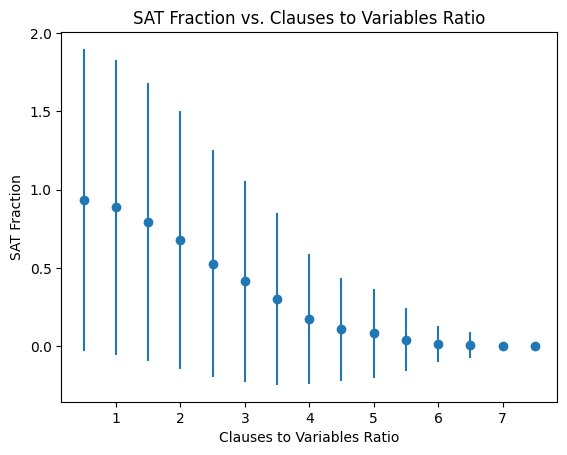

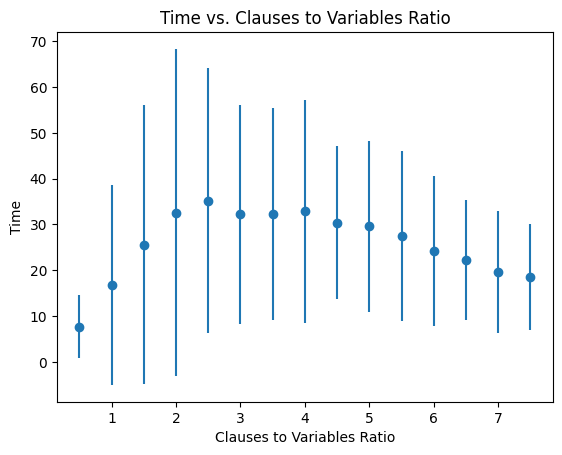

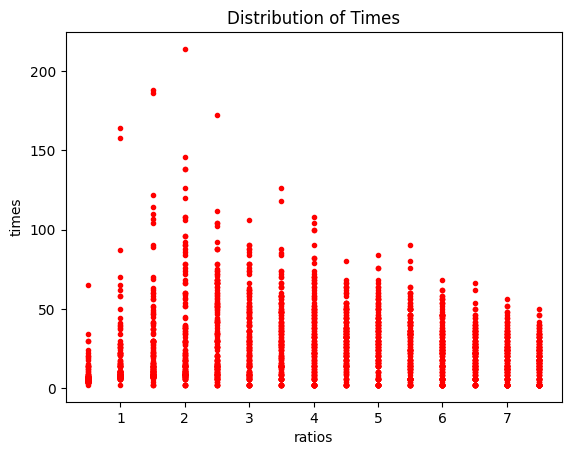

In [26]:
PlotSATFrac(7, 150, k=3, ClausesOverVars=np.arange(0.5, 8.0, 0.5), Solver=SlowDPSATSolver)

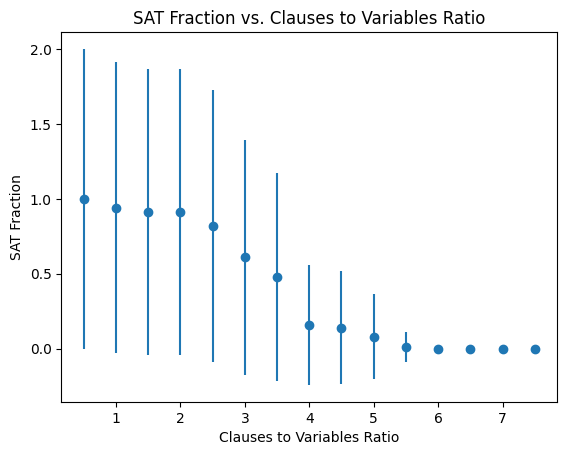

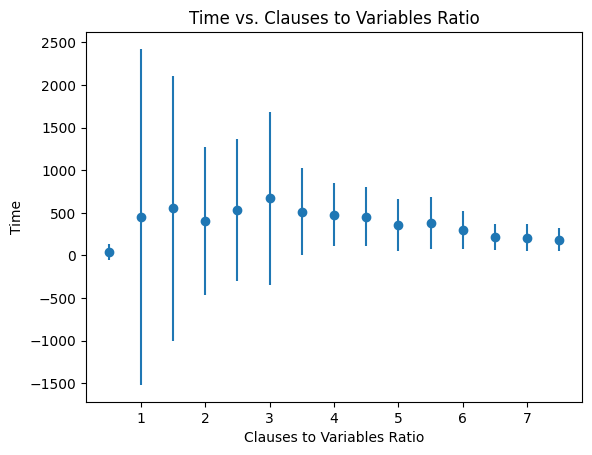

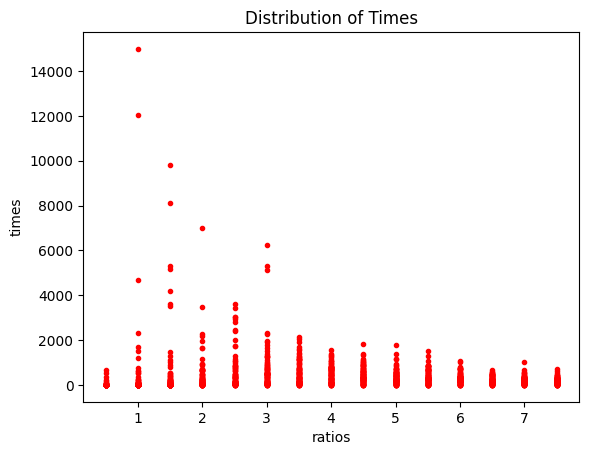

In [27]:
PlotSATFrac(15, 100, k=3, ClausesOverVars=np.arange(0.5, 8.0, 0.5), Solver=SlowDPSATSolver)

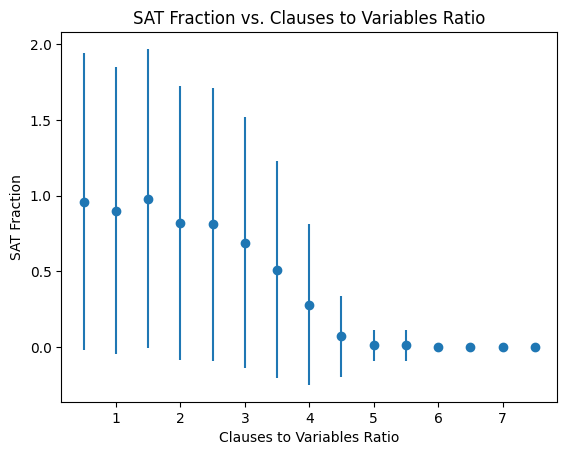

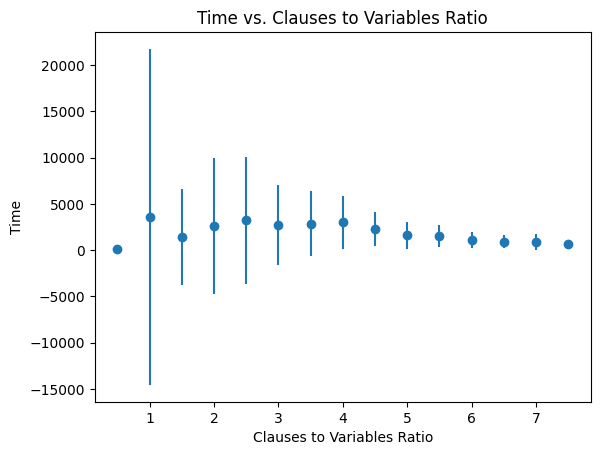

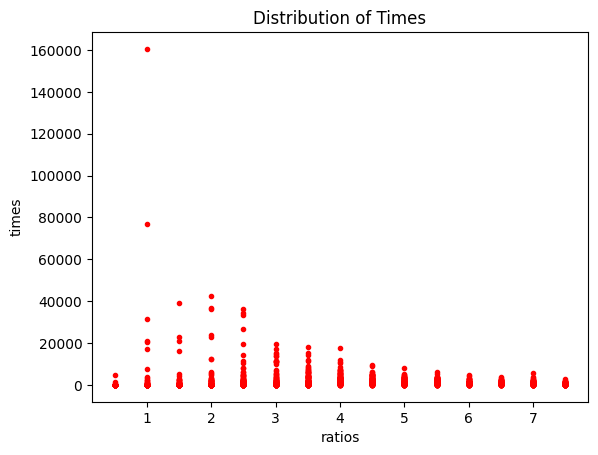

In [30]:
PlotSATFrac(20, 100, k=3, ClausesOverVars=np.arange(0.5, 8.0, 0.5), Solver=SlowDPSATSolver)

#### Exercise 6.4 Refinements
The DP algorithm can be sped up significantly with a few refinements. The most important is to remove singletons (‘length one’ clauses with all but one variable set to unfavorable values, hence deter- mining the value of the remaining variable). When reducing the clauses involving a tenta- tively set variable, notice at each stage whether any singletons remain; if so, set them and reduce again. Try your improved algorithm on larger problems. Is it faster?

In [31]:
class FasterDPSATSolver(DPSATSolverBase):

    def TrySet(self, literal):
        """Improves on SlowDPSATSolver, by looking for a `length one'
        clause where all but one literal is set wrong, and using
        TrySet recursively to set that last literal true.
        """
        var = abs(literal)
        varsSet = [var]
        clausesSet = []

        self.varStatus[var] = True if literal >= 0 else False

        for clause in self.clauseList:
            if -literal in clause:
                if self.clauseStatus[clause] != True:
                    if all(self.varStatus[abs(v)] is not None for v in clause):
                        return False, varsSet, clausesSet
        for clause in self.clauseList:
            if literal in clause and self.clauseStatus[clause] is None:
                self.clauseStatus[clause] = True
                clausesSet.append(clause)

        for clause in self.clauseList:
            if not self.clauseStatus[clause]:
                unsetLiterals = [lit for lit in clause if self.varStatus[abs(lit)] is None]
                if len(unsetLiterals) == 1:
                    status, tryVarsSet, tryClausesSet = self.TrySet(unsetLiterals[0])
                    varsSet.extend(tryVarsSet)
                    clausesSet.extend(tryClausesSet)
                    if status == False:
                        return False, varsSet, clausesSet
        return True, varsSet, clausesSet

In [32]:
solver3 = FasterDPSATSolver(clauses1)
solver4 = FasterDPSATSolver(clauses2)
print(solver3.Solve())
print(solver4.Solve())
print(solver3.Verify())
print(solver4.Verify())

(True, 2)
(False, 10)
True
False


We can see that this new version of the algorithm took 10 tries instead of 126 tries of the first version.

#### Exercise 6.5: Heavy tails and random restarts.
The DP algorithm will eventually return either a solution or a judgment of unsatisfiability, but the time it takes to return an answer fluctuates wildly from one run to another. You probably noticed this in your scatter plots of the times—a few were huge, and the others small. You might think that this is mainly because of the rare, difficult cases. Not so. The time fluctuates wildly even with repeated DP runs on the same satisfiability problem

Run the DP algorithm on a 2SAT problem many times on a single network with N = 40 variables and M = 40 clauses, randomly shuffling the order in which you select variables to flip. Estimate the power law $ρ(t) ∼ t^x$ giving the probability of the algorithm finishing after time t. Sort your variables so that the next one chosen (to be tentatively set) is the one most commonly arising (positive or negative) in the clauses. Does that speed up the algorithm? Try also reversing the order, choosing always the least used variable. Does that dramatically slow down your algorithm?

Given that shuffling the order of which spins you start with can make such a dramatic difference in the run time, why persist if you are having trouble? The discovery of the heavy tails motivates adding appropriate random restarts to the algorithm. By throwing away the effort spent exploring the neighborhood of one spin choice, one can both improve the average behavior and avoid the heavy tails.


In [33]:
def TimeTails(SATInstance, nRuns=10, MOMS=False, method=max):
    """TimeTails(SATInstance, nRuns=10, showPlot=True)
    computes and returns the times for nRuns runs of a SAT instance
    shuffling the order of the variable list vars (and hence the order
    in which they are attempted by the DP algorithm) and resetting the
    instance in between. GRAPHICS is turned off.
    Optionally, a pylab.hist plot of the histogram can be generated and shown.
    See pylab.hist and pylab.histogram
    """
    times = []
    for _ in range(nRuns):

        SATInstance.ShuffleVariableOrder()
        SATInstance.Reset()
        _, time = SATInstance.Solve(MOMS=MOMS, method=method, stop_criterion=True)
        times.append(time)
    return times

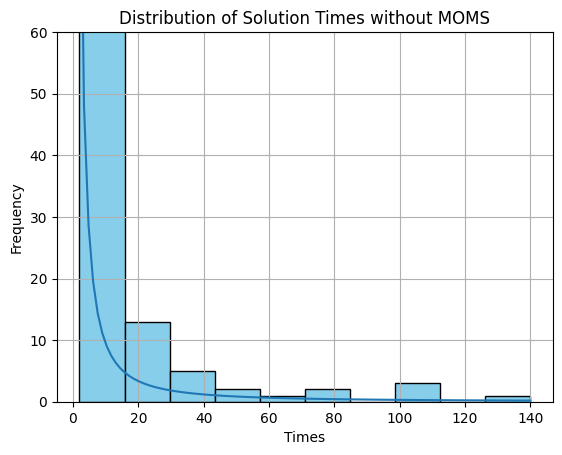

In [102]:
for _ in range(3):
  SATInstance = FasterDPSATSolver(MakeRandom_kSATClauses(40, 40, 2))
  times = TimeTails(SATInstance, nRuns=100)
x = np.linspace(min(times),max(times),100)
y = 300*x**(-1.5)
pylab.plot(x,y)
pylab.ylim(0,60)
pylab.hist(times, bins=10, color='skyblue', edgecolor='black')
pylab.xlabel('Times')
pylab.ylabel('Frequency')
pylab.title('Distribution of Solution Times without MOMS')
pylab.grid(True)
pylab.show()

The power law is similar to the one estimated in the code:

$ρ(t) ∼ 300* t^-1.5$

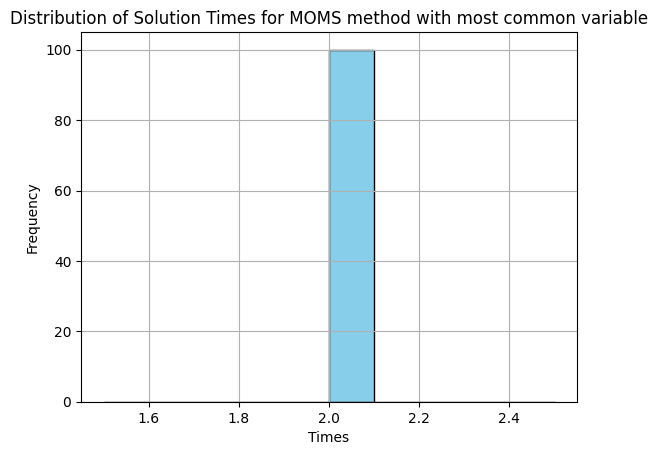

In [105]:
times = TimeTails(SATInstance, nRuns=100, MOMS=True)

pylab.hist(times, bins=10, color='skyblue', edgecolor='black')
pylab.xlabel('Times')
pylab.ylabel('Frequency')
pylab.title('Distribution of Solution Times for MOMS method with most common variable')
pylab.grid(True)
pylab.show()

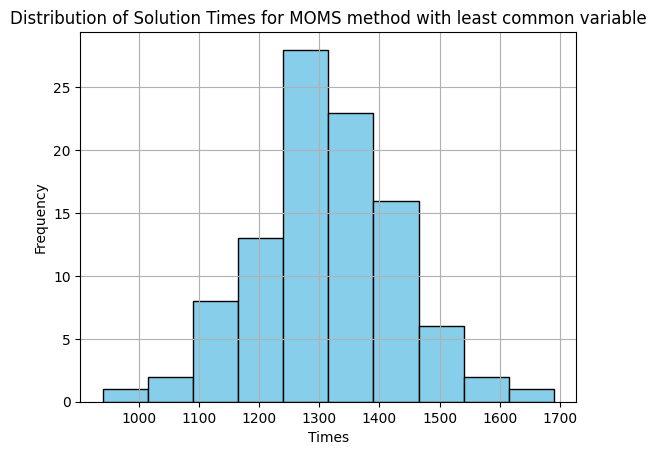

In [106]:
times = TimeTails(SATInstance, nRuns=100, MOMS=True, method=min)

pylab.hist(times, bins=10, color='skyblue', edgecolor='black')
pylab.xlabel('Times')
pylab.ylabel('Frequency')
pylab.title('Distribution of Solution Times for MOMS method with least common variable')
pylab.grid(True)
pylab.show()

In [107]:
def NTimeTails(nInst, nRuns, nVars=10, nClauses=40, k=3, Solver=FasterDPSATSolver, MOMS=False, method=max):
    """NTimeTails(nInst, nRuns, nVars, nClauses, plot=True,
    Solver=FasterDPSATSolver) computes the runtimes for nRuns runs each
    of nInst SAT instances (k-SAT with nVars variables and nClauses clauses),
    returning a list of the runtime (number of flips) of each run. Optionally,
    a pylab plot of the histogram can be generated and shown.
    see pylab.hist and pylab.histogram
    """
    all_times = []

    for _ in range(nInst):
        SATInstance = Solver(MakeRandom_kSATClauses(nVars, nClauses, k))
        print(_)
        instance_times = TimeTails(SATInstance, nRuns, MOMS=MOMS, method=method)
        all_times.extend(instance_times)

    return all_times

The graph is unbalanced because for SAT problems the algorithm take far more less than UNSAT problems.

0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19


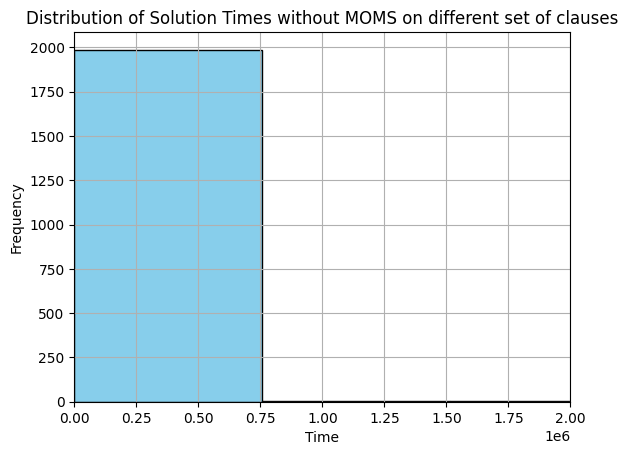

In [108]:
times = NTimeTails(20, 100, nVars=40, nClauses=40, k=2, Solver=FasterDPSATSolver)
pylab.hist(times, bins=10, color='skyblue', edgecolor='black')
pylab.xlabel('Time')
pylab.ylabel('Frequency')
pylab.xlim(0,2000000) #to see better the distribution I cut the last part of it which has very very low frequency
pylab.title('Distribution of Solution Times without MOMS on different set of clauses')
pylab.grid(True)
pylab.show()

0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19


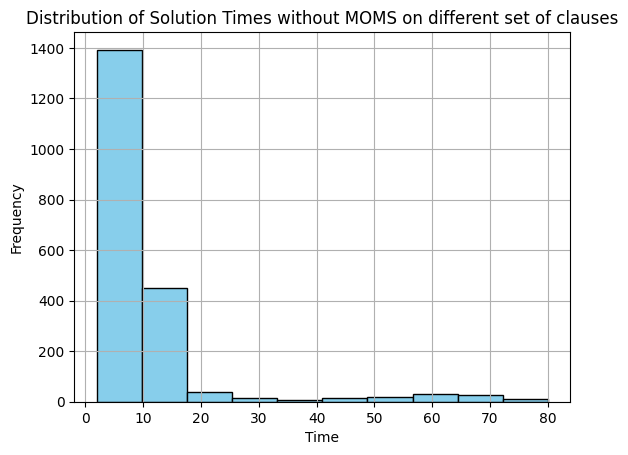

In [109]:
times = NTimeTails(20, 100, nVars=40, nClauses=40, k=2, Solver=FasterDPSATSolver,MOMS=True)
pylab.hist(times, bins=10, color='skyblue', edgecolor='black')
pylab.xlabel('Time')
pylab.ylabel('Frequency')
pylab.title('Distribution of Solution Times without MOMS on different set of clauses')
pylab.grid(True)
pylab.show()

In [51]:
def LogLogHist(seq, nBins=10, value=None):
    """LogLogHist(seq, nBins=10) makes a log-log histogram (with nBins bins)
    of a sequence of numbers contained in seq.  Bin widths are sized
    exponentially (i.e., uniformly in logs) and bin counts are normalized
    by bin width."""
    bins = np.logspace(np.log10(min(seq)), np.log10(max(seq)), nBins)
    hist, edges = np.histogram(seq, bins=bins)
    bin_widths = np.diff(edges)
    print("bin widths:", bin_widths)
    normalized_hist = hist / bin_widths


    pylab.bar(edges[:-1], normalized_hist, width=bin_widths, align='edge', edgecolor='black', linewidth=1.5)
    pylab.xscale('log')
    pylab.yscale('log')
    pylab.xlabel("Times")
    pylab.ylabel('Frequency (normalized by bin width)')
    pylab.title(f'Log-Log Histogram for {value}')
    pylab.grid(True)
    pylab.show()

In [52]:
def TimeSlowFast(nInst, nRuns, nVars, nClauses):
    """TimeSlowFast(nInst, nRuns, nVars, nClauses) compares the runtimes
    of the Slow and Faster DPSATSolvers.
    """
    slow_times = []
    fast_times = []

    print("check the iteration:")
    for _ in range(nInst):
        print(_, end=",")
        clauses = MakeRandom_kSATClauses(nVars, nClauses)

        slow_solver = SlowDPSATSolver(clauses)
        slow_total_time = 0
        for _ in range(nRuns):
            _, num_tries = slow_solver.Solve(stop_criterion=True)
            slow_total_time += num_tries
            slow_solver.Reset()  # Reset for next run
        slow_times.append(slow_total_time / nRuns)

        fast_solver = FasterDPSATSolver(clauses)
        fast_total_time = 0
        for _ in range(nRuns):
            _, num_tries = fast_solver.Solve(stop_criterion=True)
            fast_total_time += num_tries
            fast_solver.Reset()  # Reset for next run
        fast_times.append(fast_total_time / nRuns)

    return slow_times, fast_times

In [53]:
time_slow, time_fast= TimeSlowFast(50, 100, 40, 40)

check the iteration:
0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,39,40,41,42,43,44,45,46,47,48,49,

bin widths: [2.46859596e+02 1.85053487e+03 1.38721741e+04 1.03990050e+05
 7.79541151e+05 5.84367836e+06 4.38059963e+07 3.28383116e+08
 2.46166005e+09]


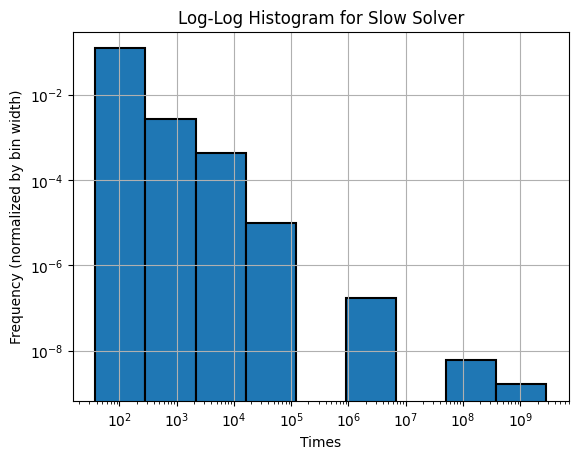

In [54]:
LogLogHist(time_slow, nBins=10, value="Slow Solver")

bin widths: [9.16732855e+01 4.57064211e+02 2.27882847e+03 1.13617716e+04
 5.66474644e+04 2.82432646e+05 1.40815128e+06 7.02075365e+06
 3.50040386e+07]


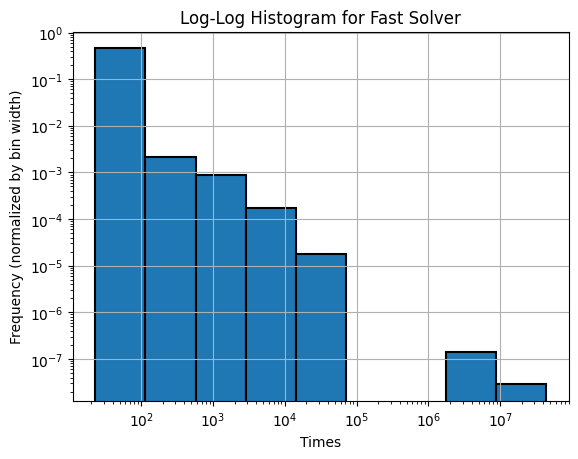

In [55]:
LogLogHist(time_fast, nBins=10, value="Fast Solver")

#### Exercise 6.6: Phase transition

It is known that 2SAT has a continuous phase transition at M/N = 1, and that 3SAT has an abrupt phase transition (albeit with critical fluctuations) near M/N = 4.25. 3SAT is thought to have severe critical slowing-down near the phase transition, whatever algorithm used to solve it. Away from the phase transition, however, the fiendishly difficult cases that take exponentially long for DP to solve are exponentially rare; DP typically will converge quickly.

Using your best algorithm, plot the fraction of 2SAT problems that are SAT for values of N = 25, 50, and 100. Does the phase transition appear to extrapolate to M/N = 1, as the literature suggests? For 3SAT, try N = 10, 20, and 30, and larger systems if your computer is fast. Is your phase transition near M/N ≈ 4.25? Sitting at the phase transition, plot the mean time (dead ends) versus N in this range. Does it appear that 2SAT is in P? Does 3SAT seem to take a time which grows exponentially?


In [56]:
def plot_2SAT_3SAT_phase_transition():
    N_values_2SAT = [25, 50, 100]
    N_values_3SAT = [10, 20, 30]

    SAT_fractions_2SAT = []
    for N in N_values_2SAT:
        #print("N:", N)
        SAT_fracs = []
        for ratio in np.arange(0.1, 5.1, 0.1):
            #print("M/N:", ratio)
            nClauses = int(ratio * N)
            SAT_fraction, _, timeAv, _ = SATFrac(N, nClauses, 10, k=2, MOMS=True)#, stop_criterion=True)
            SAT_fracs.append(SAT_fraction)
        SAT_fractions_2SAT.append(SAT_fracs)

    SAT_fractions_3SAT = []
    for N in N_values_3SAT:
        #print("N:", N)
        SAT_fracs = []
        for ratio in np.arange(0.1, 6.1, 0.1):
            #print("M/N:", ratio)
            nClauses = int(ratio * N)
            SAT_fraction, _, timeAv, _ = SATFrac(N, nClauses, 10, k=3, MOMS=True)#, stop_criterion=True)
            SAT_fracs.append(SAT_fraction)
        SAT_fractions_3SAT.append(SAT_fracs)

    pylab.figure(figsize=(10, 5))

    pylab.subplot(1, 2, 1)
    for i, N in enumerate(N_values_2SAT):
        pylab.plot(np.arange(0.1, 5.1, 0.1), SAT_fractions_2SAT[i], label=f'N={N}')
    pylab.axvline(x=1, color='r', linestyle='--', label='Phase Transition (M/N = 1)')
    pylab.xlabel('M/N')
    pylab.ylabel('SAT Fraction')
    pylab.title('2SAT Phase Transition')
    pylab.legend()

    pylab.subplot(1, 2, 2)
    for i, N in enumerate(N_values_3SAT):
        pylab.plot(np.arange(0.1, 6.1, 0.1), SAT_fractions_3SAT[i], label=f'N={N}')
    pylab.axvline(x=4.25, color='r', linestyle='--', label='Phase Transition (M/N ≈ 4.25)')
    pylab.xlabel('M/N')
    pylab.ylabel('SAT Fraction')
    pylab.title('3SAT Phase Transition')
    pylab.legend()

    pylab.tight_layout()
    pylab.show()

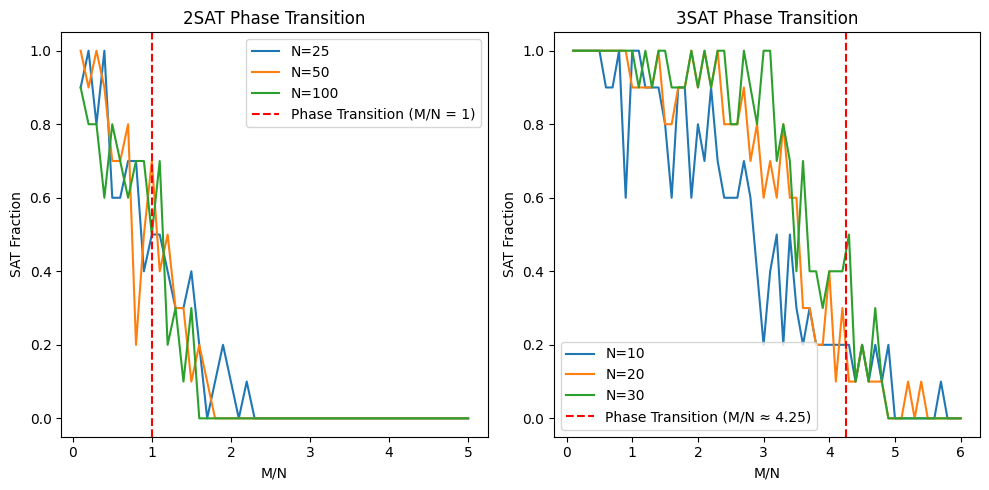

In [57]:
plot_2SAT_3SAT_phase_transition()

For 2SAT the phase transition is the one expected in the theory, while for 3SAT we get a different value (around 3.50).

Text(0.5, 1.0, 'M/N=1 phase transition')

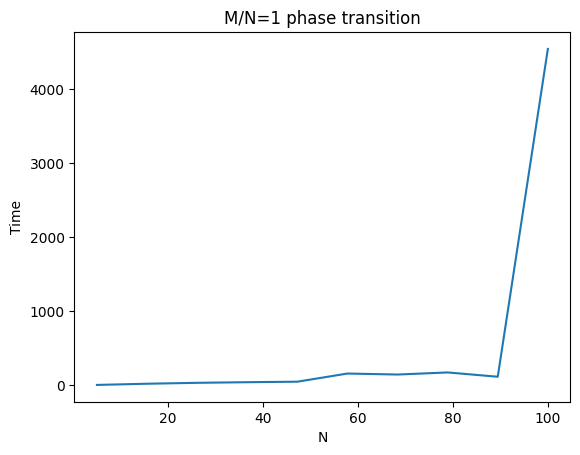

In [104]:
N_values_2SAT = np.linspace(5,100,10)
times_2SAT = []
for N in N_values_2SAT:
    N=round(N)
    M=N #ratio = 1
    _, _, timeAv, _ = SATFrac(N, M, 10, k=2, MOMS=True)#, stop_criterion=True)
    times_2SAT.append(timeAv)

pylab.plot(N_values_2SAT, times_2SAT)
pylab.xlabel('N')
pylab.ylabel('Time')
pylab.title('M/N=1 phase transition')

2SAT is not P since it starts to grows exponentially from 90.

Text(0.5, 1.0, 'M/N=4.25 phase transition for 3Sat problems')

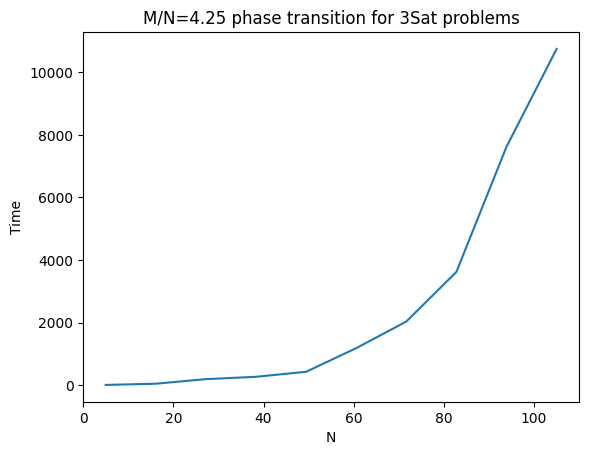

In [59]:
N_values_3SAT = np.linspace(5,105,10)
times_3SAT = []
for N in N_values_3SAT:
    N=round(N)
    M=round(N*4.25)
    _, _, timeAv, _ = SATFrac(N, M, 10, k=3, MOMS=True)#, stop_criterion=True)
    times_3SAT.append(timeAv)

pylab.plot(N_values_3SAT, times_3SAT)
pylab.xlabel('N')
pylab.ylabel('Time')
pylab.title('M/N=4.25 phase transition for 3Sat problems')

3SAT is not P since it starts to grows exponentially from the beginning.